This example shows an application of adaptive dynamic programming (ADP) to a linear system with a constant disturbance term. By combining the output regulation technique, the ADP-based control algorithm can find the optimal control policy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.linalg import null_space
from numpy.linalg import matrix_rank
import scipy.io
from scipy import signal
from cvxopt import matrix, solvers
import pylab
import math
import random
from sklearn import linear_model
solvers.options['show_progress'] = False

Problem 1: 
Objective: find $X^*$ and $U^*$, minimizing  $Tr(X^T\bar{Q}X + U^T\bar{R}U)$ , subject to

$$\begin{equation*}
\begin{aligned}
\hat{E} = AX + BU + \hat{D} \quad (10)\\
0 = CX + \hat{F} \quad (11) \\
\text{with }L = U + KX \quad(12)
\end{aligned}
\end{equation*}$$


Define a Sylvester map $S:\mathbb{R}^{n\times q_m} \rightarrow \mathbb{R}^{n\times q_m}$ by:
$$\begin{equation*}
S(X) = X\hat{E} - AX, X\in q_m \quad(20)
\end{equation*}
$$
Pick constant matrix $X_1 \in \mathbb{R}^{n\times q_m}$ such that $CX_1 + \hat{F} = 0$, then select $ X_i \in \mathbb{R}^{n\times q_m}$ for $ i = 2,...,h+1$ such that all vectors $vec(X_i)$ form a basis for $ker(I_{q_m} \otimes C)$, where $ h = (n-r)q_m$

where $m = 1, q = 1, q_m = 1, r = 2, n = 4, h = (n - r)q_m$


Solve problem 2 first, get $K_{j^*}$. Then use $K_{j^*}$ to get $S(x_1) ... S(x_{h+1})$ with $j = j^*$ and $ B = P_{j^*}^{-1}K^T_{j^*}R $. 
With S and B we have M and N.
Then solve problem 1 with cost defined by $\bar{Q}$ and $\bar{R}$ as a convex optimization problem.

In [1414]:
#parameters for a passenger sedan
vx = 10.0
C_alphaf = 80000
C_alphar = 80000
m = 1573
lf = 1.1
lr = 1.58
Iz = 2873

A = np.array([[0.0, 1.0, 0.0, 0.0], 
              [0.0, -2*(C_alphaf+C_alphar)/(m*vx), 2*(C_alphaf+C_alphar)/m, -2*(C_alphaf*lf-C_alphar*lr)/(m*vx)],
             [0.0, 0.0, 0.0, 1.0],
             [0.0, -2*(C_alphaf*lf-C_alphar*lr)/(Iz*vx), 2*(C_alphaf*lf-C_alphar*lr)/Iz, -2*(C_alphaf*(lf**2)+C_alphar*(lr**2))/(Iz*vx)]
             ])

# A = np.array([[0.0, 0.0, 0.0, 1.0], 
#               [0.0, -2*(C_alphaf*(lf**2)+C_alphar*(lr**2))/(Iz*vx), 2*(C_alphaf*lf-C_alphar*lr)/Iz, -2*(C_alphaf*lf-C_alphar*lr)/(Iz*vx)],
#              [0.0, 1.0, 0.0, 0.0],
#               [0.0, -2*(C_alphaf*lf-C_alphar*lr)/(m*vx), 2*(C_alphaf+C_alphar)/m, -2*(C_alphaf+C_alphar)/(m*vx)]
#              ])

B = np.array([[0.0],
              [2*C_alphaf/m],
               [0.0],
              [2*C_alphaf*lf/Iz]
             ])

# B = np.array([[0.0],
#               [2*C_alphaf*lf/Iz],
#               [0.0],
#               [2*C_alphaf/m]
#              ])

C = np.array([[1.0, 0.0, 0.0, 0.0],
             [0.0, 1.0, 0.0, 0.0],
             [0.0, 0.0, 1.0, 0.0],
             [0.0, 0.0, 0.0, 0.6]])

F = np.array([[0.0],
             [0.0],
             [0.0],
             [0.4]])

D = np.array([[0.0], 
            [-2*(C_alphaf*lf-C_alphar*lr)/(m*vx) - vx],
            [0.0],
            [-2*(C_alphaf*(lf**2)+C_alphar*(lr**2))/(Iz*vx)]
             ])

# D = np.array([[0.0], 
#             [-2*(C_alphaf*(lf**2)+C_alphar*(lr**2))/(Iz*vx)],
#             [0.0],
#             [-2*(C_alphaf*lf-C_alphar*lr)/(m*vx) - vx],
#              ])


# parameters for matrix shape

m = 1
q = 1
qm = 1
r = 4
n = 4
h = (n-r)*qm
Pi = 3.141
dt = 1e-3


# vehicle dynamics
def env(x, u, dpsi):
    x_ = x + dt*(A @ x + B @ u + D @ dpsi)
#     x_ = x + dt*(A @ x + B @ u)
    return x_


# train over different curvature. (Truning radius for 1 to 20m)

W = [round(1.0/r,3) for r in range(8, 21)] + [0.0]

In [1415]:
tv = np.arange(1,5).reshape(4,1)
A_@tv

array([[   2.        ],
       [ 589.14176732],
       [   4.        ],
       [-157.41371389]])

In [1416]:
tv2 = np.array([1,2,3,4])[:, np.newaxis]
A@tv2

array([[   2.        ],
       [ 589.14176732],
       [   4.        ],
       [-157.41371389]])

In [1417]:
# Select basis for ker(np.kron(Iqm, C)) as Xi, i = 1...h+1. X0 is a constant matrix s.t. CX0 = 0
Iqm = np.eye(1)
ns_C = null_space(np.kron(Iqm, C))
X = [np.zeros((n, qm)) for _ in range(h+2)]
X[1] = np.array([0.0, 0.0, 0.0, -2/3*vx])[:, np.newaxis]
for i in range(2, h+2):
    X[i] = ns_C[:,i-2:i-1]

X

[array([[0.],
        [0.],
        [0.],
        [0.]]),
 array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-6.66666667]])]

In [1418]:
C@X[1]

array([[ 0.],
       [ 0.],
       [ 0.],
       [-4.]])

In [1419]:
#generate waypoints based on curvature
def waypoints_generator(r):
    res = []
    return res

#check if rank condition of X holds, according to (29)

#X = [gamma_xi_xi, gamma_xi_u, gamma_xi_w]

#

Initial control policy

In [1420]:
# current best poles??
Poles = np.array([-0.8,-0.88, -1.0, -1.1])
K0 = signal.place_poles(A, B, Poles).gain_matrix

In [1421]:
K0

array([[ 5.10099542e-05, -6.71873432e-01,  6.72084484e+00,
         5.08260092e-01]])

Model-free method to solve the control problem

In [1422]:
# Simulation
memory_size = int(1e7)
# variance of the exploration noise
sigma = 0.1
w0 = 1.0/8
x_init = np.array([1.0, vx*math.tan(Pi/12) + vx*Pi/12, Pi/12, vx*w0])[:, np.newaxis]

# memory matrices
gamma_xx = [np.zeros((n*n, memory_size)) for _ in range(h+2)]
gamma_xu = [np.zeros((n*m, memory_size)) for _ in range(h+2)]
gamma_xw = [np.zeros((n*q, memory_size//q)) for _ in range(h+2)]
delta_xx = [np.zeros((n*(n+1)//2, memory_size)) for _ in range(h+2)]
# initialize u
u = -K0@x_init

# vecv operation
def vecv(x):
    l = len(x)
    a = np.arange(l*l).reshape(l, l)
    index_vecv = np.triu_indices(l)
    tmp = a[index_vecv]
    kron_product = np.kron(x, x)
    result = kron_product[tmp]
    return result

# vecs operation
def vecs(c):
    l = c.shape[0]
    a = np.arange(l*l).reshape(l, l)
    index_vecs1 = np.triu_indices(l)
    index_vecs2 = np.triu_indices(l,1)
    c[index_vecs2] *= 2
    return c[index_vecs1]

# collect data for gamma_xx, gamma_xu, gamma_xw and delta_xx
step = 0
x = x_init
while True:
    for w in W:
        w = np.array([[w]])
        for j in range(1000):
            noise = np.random.normal(np.array([0]), np.array([sigma]))[:, np.newaxis]
            u = -K0@x + noise
            newx = env(x, u, vx*w)
            for i in range(h+2):
                x_bar = x - (X[i]@w)
                newx_bar = newx - (X[i]@w)
                gamma_xx[i][:,step:step+1] = dt * np.kron(x_bar, x_bar)
                gamma_xu[i][:,step:step+1] = dt * np.kron(x_bar, u)
                gamma_xw[i][:,step:step+1] = dt * np.kron(x_bar, w)
                delta_xx[i][:,step:step+1] = vecv(newx_bar) - vecv(x_bar)
            x = newx
            step += 1
    
    # check if meet rank condition, should be n(n+1)/2 + (m+qm)n = 18
    meet_rank_condition = True
    for i in range(h+2):
        if matrix_rank(np.hstack((gamma_xx[i][:, :step].T, gamma_xu[i][:, :step].T, gamma_xw[i][:, :step].T))) < 18:
            meet_rank_condition = False 
    
    if meet_rank_condition:
        print("Break at " + str(step))
        for i in range(h+2):
            print(matrix_rank(np.hstack((gamma_xx[i][:, :step].T, gamma_xu[i][:, :step].T, gamma_xw[i][:, :step].T))))
        break
    else: print("Exploring: " + str(step))
        
for i in range(h+2):
    gamma_xx[i] = gamma_xx[i][:, :step]
    gamma_xu[i] = gamma_xu[i][:, :step]
    gamma_xw[i] = gamma_xw[i][:, :step]
    delta_xx[i] = delta_xx[i][:, :step]

memory_size = step

Break at 14000
18
18


In [1423]:
#cost design for problem 2
Q = np.array([[100, 0, 0, 0],
              [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])
R = np.array([[0.1]])

In [1424]:
Psi = [np.zeros((memory_size,18)) for _ in range(h+2)]
Phi = [np.zeros((memory_size,1)) for _ in range(h+2)]
In = np.eye(4)
def vec(c):
    return c.flatten('F')[:,np.newaxis]

def Psi_update(i, K_):
    Psi[i] = np.hstack((delta_xx[i].T, -2*gamma_xx[i].T@np.kron(In, K_.T@R)-2*gamma_xu[i].T@np.kron(In,R), -2*gamma_xw[i].T))

def Phi_update(i, K_):
    Phi[i] = -(gamma_xx[i].T)@vec(Q+K_.T@R@K_)

# Initialize Psi and Phi
for i in range(h+2):
    Psi_update(i, K0)
    Phi_update(i, K0)
    

In [1425]:
## algorithm begins here
iter_max = 100
# size_XY = time_max
# size_batch = 1
# size_memory = memory.shape[0]

# Solve Pj, Kj+1 until norm(Pj - Pj-1) < 1e-2
K = [np.zeros((m,n))for _ in range(h+2)]
P = [np.zeros((n,n)) for _ in range(h+2)]
Pstar = np.zeros((n,n))
Kstar = np.zeros((m,n))
Vstar = [np.zeros((n, 1)) for _ in range(h+2)]
errP = np.zeros((h+2,iter_max))
errK = np.zeros((h+2,iter_max))
clf = linear_model.LinearRegression()
P_vecs_size = n*(n+1)//2
for i in range(h+2):
    err_P = float('inf')
    Ppre = np.array([])
    Kpre = np.array([])
    for j in range(iter_max):
#         pp = scipy.linalg.lstsq(Psi[i], Phi[i])[0]
        clf.fit(Psi[i], Phi[i])
        pp = clf.coef_.T
        P_vecs = pp[:P_vecs_size, :]
        K_vec = pp[P_vecs_size: P_vecs_size+n, :]
        K[i] = K_vec.T 
        temp5 = np.zeros((n,n))
        l = 0
        for t1 in range(n):
            for t2 in range(t1, n):
                temp5[t1, t2] = P_vecs[l]
                l = l+1

        P[i] = (temp5 + temp5.T)/2.0
        if Ppre.any():
            err_P = np.linalg.norm(P[i] - Ppre)
            errP[i,j-1] = err_P
        
        Ppre = P[i]
        if Kpre.any():
            err_K = np.linalg.norm(K[i] - Kpre)
            errK[i,j-1] = err_K
        
        Kpre = K[i]
        Psi_update(i, K[i])
        Phi_update(i, K[i])
        
        if (err_P < 1e-2):
            Pstar = P[i]
            Kstar = K[i]
            Vstar[i] = pp[P_vecs_size+n:,:] 
            print("Break at j = " + str(j) + ", i = " + str(i))
#             print(K[i])
            print(pp[P_vecs_size+n:,:])
            break
            
#         if j == iter_max-1:
#             Pstar = P[i]
#             Kstar = K[i]
#             Vstar[i] = pp[P_vecs_size+n:,:] 
            

Break at j = 31, i = 0
[[21.80271829]
 [ 1.47358859]
 [ 1.7306366 ]
 [-3.12550878]]
Break at j = 31, i = 1
[[ -4.67195778]
 [ -0.18364737]
 [-21.67960718]
 [ -0.37509651]]


In [1426]:
P_vecs.shape

(10, 1)

Plots show convergence of K and P values

In [1427]:
##plots 
fontsize_xylabel = 18
fontsize_ticks = 10
fontsize_legend = 16
linewidth=1
markersize=3

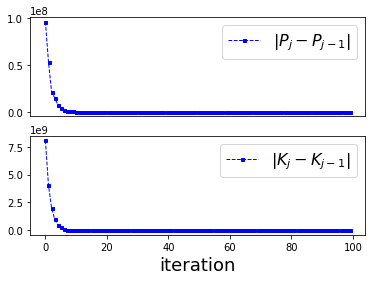

In [1428]:
try:
    errP = np.trim_zeros(errP)
except:
    pass

try:
    errK = np.trim_zeros(errK)
except:
    pass

plt.figure(5)
plt.subplot(211)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(errP[1,1:],'bs--',linewidth=linewidth, label=r'$|P_{j}-P_{j-1}|$', markersize=markersize)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(errK[1,:],'bs--',linewidth=linewidth, label=r'$|K_{j}-K_{j-1}|$', markersize=markersize)
plt.xlabel('iteration', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)

Solve L with ADP (system unknown)

In [1429]:
## cost (reward) design
# For perfect result : use
# Q_bar = np.array([[1, 0, 0, 0],
#               [0, 2.5e7, 0, 0],
#              [0, 0, 1e9, 0],
#              [0, 0, 0, 1e9]])
# R_bar = np.array([[1.5e5]])

Q_bar = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])
R_bar = np.array([[1]])

In [1430]:
# Repeat solving S(Xi) from (36): Learnt S
S = [np.zeros((n,qm)) for _ in range(h+2)]
D_hat = (Vstar[0].T @ scipy.linalg.inv((Pstar))).T
for i in range(1, h+2):
    S[i] = (D_hat.T - (Vstar[i].T @ scipy.linalg.inv((Pstar)))).T

# Learnt B
B_ = scipy.linalg.inv((Pstar))@Kstar.T@R

## Get M and N:
# Get Alpha and b
l_Alpha = h+n*qm+m*qm 
Alpha = np.zeros((n*2, l_Alpha))
b = np.zeros((n*2,1))

for i in range(2,h+2):
    Alpha[:n, i-2:i-1] = vec(S[i])
    Alpha[n:, i-2:i-1] = vec(X[i])
    
Alpha[:qm*n, -1:] = np.kron(-np.eye(qm), B_)
Alpha[n*qm:, h:h+n*qm] = -np.eye(n*qm)
b = np.vstack((vec(-S[1] + D_hat), vec(-X[1])))

A_11 = Alpha[:2*n-h, :h]
A_21 = Alpha[2*n-h:, :h]
A_12 = Alpha[:2*n-h, h:]
A_22 = Alpha[2*n-h:, h:]

b1 = b[h:]
b2 = b[:h]

M = (-A_11)@np.linalg.inv((A_21))@A_22 + A_12
N = (-A_11)@np.linalg.inv((A_21))@b2 + b1

# Get Xstar and Ustar:

Temp = np.zeros((n*qm+m*qm, n*qm+m*qm))
Temp[:n*qm,:n*qm] = np.kron(np.eye(qm), Q_bar)
Temp[n*qm:,n*qm:] = np.kron(np.eye(qm), R_bar)

#cvxopt.solvers.coneqp(P, q[, G, h[, dims[, A, b[, initvals[, kktsolver]]]]])
H = np.zeros((n*qm+m*qm, 1))
G = np.zeros((n*qm+m*qm, n*qm+m*qm))
sol = solvers.qp(matrix(Temp), matrix(np.zeros((n*qm+m*qm, 1))), matrix(G), matrix(H), matrix(M), matrix(N), kktsolver='ldl', options={'kktreg':1e-9})
Xstar = sol['x'][:n*qm]
Ustar = sol['x'][n*qm:]
Lstar = Ustar + Kstar@Xstar

     pcost       dcost       gap    pres   dres
 0:  2.2665e+01  3.1413e+11  5e+00  2e+00  4e-05
 1:  2.2665e+01  6.2512e+11  5e-02  2e-01  6e-05
 2:  2.2665e+01  9.3611e+11  5e-04  2e-01  2e-04
 3:  2.2665e+01  1.2471e+12  5e-06  2e-01  1e-04
 4:  2.2665e+01  1.5581e+12  5e-08  2e-01  1e-04
 5:  2.2665e+01  1.8691e+12  5e-10  2e-01  3e-04
 6:  2.2665e+01  2.1801e+12  5e-12  2e-01  1e-03
 7:  2.2665e+01  2.4911e+12  5e-14  2e-01  2e-04
 8:  2.2665e+01  2.8020e+12  5e-16  2e-01  1e-03
 9:  2.2665e+01  3.1130e+12  5e-18  2e-01  3e-04
10:  2.2665e+01  3.4240e+12  5e-20  2e-01  5e-04
11:  2.2665e+01  3.7350e+12  5e-22  2e-01  7e-04
12:  2.2665e+01  4.0460e+12  5e-24  2e-01  2e-03
13:  2.2665e+01  4.3570e+12  5e-26  2e-01  8e-04
14:  2.2665e+01  4.6680e+12  5e-28  2e-01  4e-04
15:  2.2665e+01  4.9790e+12  5e-30  2e-01  2e-03
16:  2.2665e+01  5.2900e+12  5e-32  2e-01  3e-03
17:  2.2665e+01  5.6010e+12  5e-34  2e-01  2e-03
18:  2.2665e+01  5.9119e+12  5e-36  2e-01  7e-04
19:  2.2665e+01  6.22

In [1431]:
B

array([[  0.        ],
       [101.71646535],
       [  0.        ],
       [ 61.26000696]])

In [1432]:
B_

array([[-2.80889502e-02],
       [ 1.06273522e+02],
       [-8.09665120e-02],
       [ 6.21791845e+01]])

In [1433]:
D

array([[  0.        ],
       [ -5.11760966],
       [  0.        ],
       [-20.64128089]])

In [1434]:
D_hat

array([[ 2.01387576e-02],
       [-4.67308464e+01],
       [ 1.11764755e-01],
       [-2.00388464e+02]])

In [1435]:
B*Ustar

array([[ 0.        ],
       [95.68730139],
       [ 0.        ],
       [57.62886794]])

In [1436]:
print(Ustar)

[ 9.41e-01]



In [1437]:
print(Xstar)

[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[-6.67e+00]



In [1438]:
A@Xstar

array([[  0.        ],
       [-32.54926891],
       [ -6.66666667],
       [137.60853927]])

In [1439]:
D*vx

array([[   0.        ],
       [ -51.17609663],
       [   0.        ],
       [-206.41280891]])

In [1440]:
A@Xstar + B_*Ustar + D_hat

array([[-6.28524201e-03],
       [ 2.06941265e+01],
       [-6.63106920e+00],
       [-4.28636278e+00]])

Lstar with known system:

In [1449]:
#Test ADP contoller
time_simulation_adp = 28000
x_traj_after_learning = np.zeros((4, time_simulation_adp))
u_traj_after_learning = np.zeros((1, time_simulation_adp))
#x = np.random.normal(np.array([0.5, 0.5]), np.array([0.0, 0.0]))[:, np.newaxis]
random.shuffle(W)
x_ = np.array([0.1, vx*math.tan(Pi/12) + vx*Pi/12, Pi/12, vx*W[0]])[:, np.newaxis]
i = 0

for w in W:
    print(w)
    for _ in range(time_simulation_adp//len(W)):
        x = x_
        u = -Kstar @ x + Lstar * w
        x_ = env(x, u, vx*np.array([[w]]))
        x_traj_after_learning[:, i] = x_.reshape((4))
        u_traj_after_learning[:, i] = u.reshape((1))
        i += 1

0.056
0.091
0.083
0.125
0.1
0.062
0.053
0.067
0.0
0.111
0.059
0.077
0.05
0.071


In [1450]:
##plots 
fontsize_xylabel = 12
fontsize_ticks = 12
fontsize_legend = 10
linewidth=2
markersize=3

Plots for state trajectory(Controler validation)

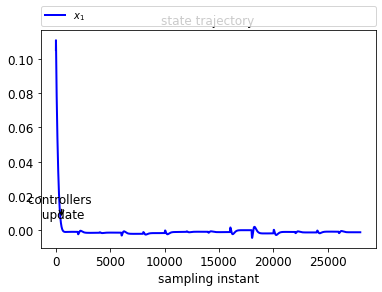

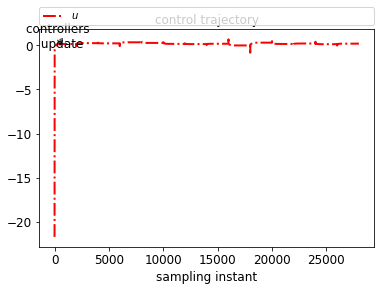

In [1452]:
# x_traj_0_whole = np.concatenate((x_traj_0[:, np.newaxis], x_traj_after_learning[0,:][:, np.newaxis]), axis=0)
# x_traj_1_whole = np.concatenate((x_traj_1[:, np.newaxis], x_traj_after_learning[1,:][:, np.newaxis]), axis=0)
time_max = 500
plt.figure(0)
plt.title('state trajectory')
plt.plot(x_traj_after_learning[0,:], linestyle='-', linewidth=linewidth, color='blue', label=r'${x}_1$')
#plt.plot(x_traj_1_whole, linestyle='-.', linewidth=linewidth, color='red', label=r'${x}_2$')
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.annotate(
        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
        xy=(time_max, 0.007), arrowprops=dict(arrowstyle='->'), xytext=(time_max+20, 0.007))
lgd = pylab.legend(fontsize=fontsize_legend,loc=3, mode="expand", bbox_to_anchor=(0., 1.02, 1., .102), 
                   ncol=4, borderaxespad=0.)
art = []
art.append(lgd)
#pylab.savefig("VI_x_traj.png", additional_artists=art, bbox_inches="tight",dpi=200)

plt.figure(1)
plt.title('control trajectory')
#plt.plot(x_traj_0_whole, linestyle='-', linewidth=linewidth, color='blue', label=r'${x}_1$')
plt.plot(u_traj_after_learning[0,:], linestyle='-.', linewidth=linewidth, color='red', label=r'${u}$')
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.annotate(
        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
        xy=(time_max, -0.3), arrowprops=dict(arrowstyle='->'), xytext=(time_max+20, -0.3))
lgd = pylab.legend(fontsize=fontsize_legend,loc=3, mode="expand", bbox_to_anchor=(0., 1.02, 1., .102), 
                   ncol=4, borderaxespad=0.)
art = []
art.append(lgd)